# Epitope mapping results for M.bovis (part 2)
## EMIDA antigen mining project


### Reference:

**Integrated computational prediction and experimental validation identifies promiscuous T cell epitopes in the proteome of pathogenic mycobacteria.** Damien Farrell, Gareth Jones, Chris Pirson, Kerri M Malone, Kevin Rue-Albrecht, Anthony J Chubb, H Martin Vordermeier, Stephen V. Gordon. 2016


In [16]:
import os,sys
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
home = os.path.expanduser('~')
#we still need the older version of the module for repeating the original work
sys.path.append(os.path.join(home,'python/sandbox/mhcpredict'))
import Base, Genome, Tepitope, EpitopePipeline
from matplotlib_venn import venn2,venn3
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth',80)
import seaborn as sns
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7','axes.grid': False,'legend.frameon':True, 'legend.fontsize':12})
sns.set_context("notebook", font_scale=1.4)
plt.rcParams['savefig.dpi']=150
from IPython.display import display, HTML
#newer module version we use for remainder of analysis
from epitopepredict import base, analysis, sequtils, utilities

In [17]:
genome = sequtils.genbank2Dataframe('MTB-H37Rv.gb', cds=True)
mbovis = sequtils.genbank2Dataframe('Mbovis.gb', cds=True)

In [18]:
#srm data
srm = pd.read_csv('srm_mtb.csv')
srm = genome.merge(srm[['locus_tag','concentration']],on='locus_tag',how='inner')
srm = srm[srm.concentration>0]
print len(srm)
#srm = srm[srm.length<=400]
#print len(srm)

1870


In [9]:
n=3
minsize=2
mhc1alleles = ['BoLA-N:00101','BoLA-N:00201','BoLA-N:00301','BoLA-N:00401',
                 'BoLA-N:00501','BoLA-N:00601','BoLA-N:00801','BoLA-N:00901',
                 'BoLA-N:01001']
otherbinders = {}
otherbinders['iedbmhc1_9'] = pd.read_csv('binders_MTB-H37Rv_iedbmhc1_9_3.csv')
otherbinders['iedbmhc1_11'] = pd.read_csv('binders_MTB-H37Rv_iedbmhc1_11_3.csv')
otherbinders['tepitope'] = pd.read_csv('binders_MTB-H37Rv_tepitope_bovine_3.csv')
otherbinders['netmhciipan'] = pd.read_csv('binders_MTB-H37Rv_netmhciipan_bovine_3.csv')
mapping = pd.read_csv('mbovis_mapping_new.csv',usecols=[1,2,3,4])#,index_col=0)

#show filtered numbers (done inside the pipeline)
for n in otherbinders:    
    d=otherbinders[n]
    dsrm = d.merge(srm[['locus_tag','length']],left_on='name',right_on='locus_tag')
    print n, len(d), len(dsrm), len(dsrm[dsrm.length>400])

iedbmhc1_9 45480 22458 12388
iedbmhc1_11 47500 23203 12746
netmhciipan 27155 14152 7584
tepitope 47370 24172 13004


In [4]:
def responsesbreakdown(res, key1='#pos',key2='method',label=''):
    sns.set_context("notebook", font_scale=1.4)
    s = res.groupby([key1,key2]).agg({'id':np.size})
    s = s.unstack(key2)
    s.columns = s.columns.get_level_values(1)
    perc = s.sum(1)
    s=s.sort(axis=1,ascending=False)
    #print s
    f,ax=plt.subplots(1,2,figsize=(10,5))
    grid=ax.flat
    perc.plot(kind='pie',ax=grid[0],cmap='Greens',figsize=(9.5,5),startangle=0)
    grid[0].set_title('%s (all methods)' %label,fontsize=18)
    grid[0].set_ylabel('')
    s.plot(kind='barh', grid=False,ax=grid[1])
    grid[1].set_title('%s per method' %label,fontsize=20)
    grid[1].set_ylabel('')
    sns.despine()
    plt.tight_layout()    
    t=s.T
    t=t.fillna(0)  
    #print t
    #print t[t.columns[t.columns>=1]].sum(1)
    print t.sum()
    #en = t[t.columns[t.columns>=1]].sum(1)/t.sum(1)
    return t

def hydroplot(res, key):
    res.boxplot('hydro',by=key,vert=False,grid=False)
    plt.title('peptide hydrophobicity by response')
    plt.suptitle('')
    plt.xlabel('hydrophobicity'); plt.ylabel(key)
    plt.tight_layout()
    plt.savefig('responses_hydrophobicity.png')

### VLA whole blood results:

               tag  #pos
0      CFP10.1_300     2
1      CFP10.2_301     2
2      CFP10.7_302     3
3      CFP10.8_303     2
4      CFP10.9_304     4
5   ESAT-6 p45_305     4
6   ESAT-6 p46_306     3
7   ESAT-6 p47_307     3
8   ESAT-6 p51_308     4
9   ESAT-6 p52_309     4
10  ESAT-6 p53_310     4
11  ESAT-6 p55_311     4
#pos
0    171
1     26
2     37
3     24
4     24
dtype: float64


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(....) is deprecated, use sort_index(.....)


#pos,0,1,2,3,4,%pos
method,,,,,,
topsharedbinders,67,8,5,9,5,28.723404
cl_tepitopepan,52,6,17,8,5,40.909091
cl_netmhciipan,52,12,12,4,8,40.909091
_pos ctrls,0,0,3,3,6,100.000000


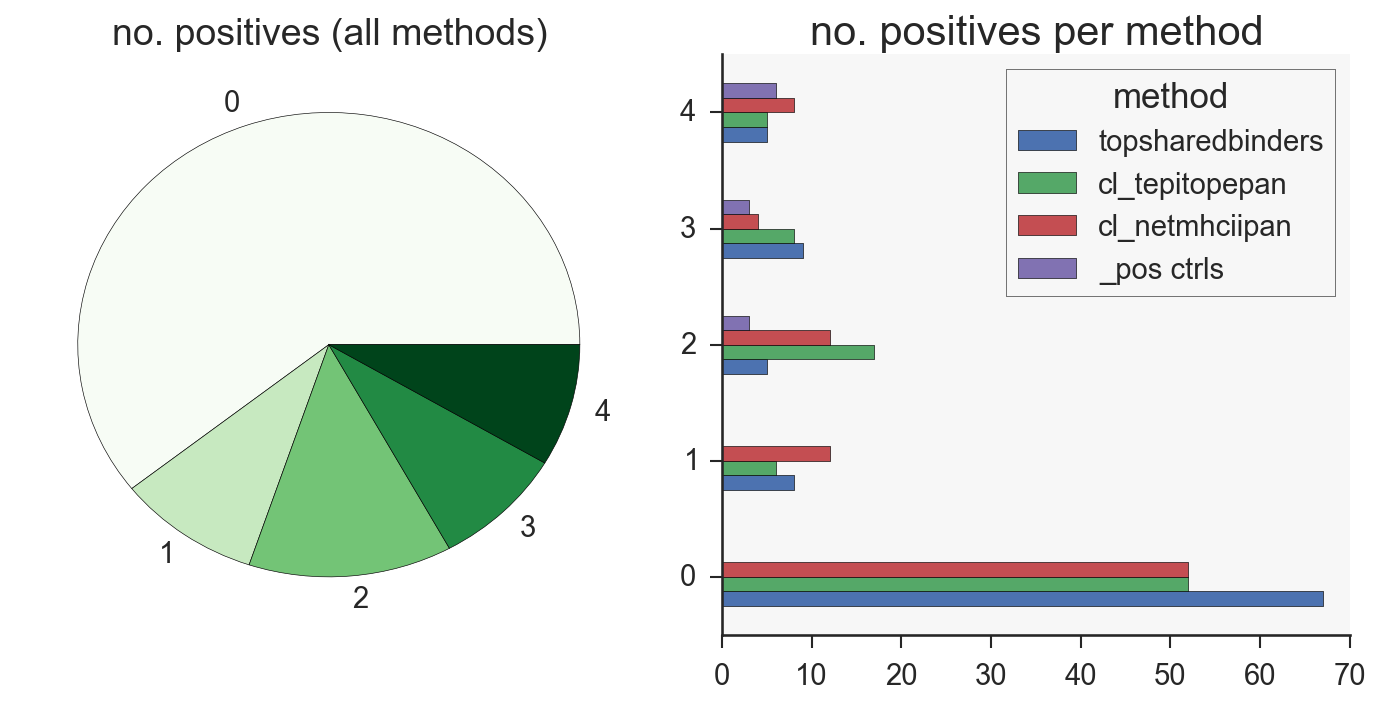

In [5]:
EpitopePipeline=reload(EpitopePipeline)
plt.rcParams['font.size']=20
sns.set_style("ticks", {'axes.facecolor': '#F7F7F7','legend.frameon': True})

#reload peptide list
plist = pd.read_csv('peptide_lists.csv',index_col=0)
#whole blood
wb = pd.read_csv('vla_wholeblood_results.csv')
wbcols = ['8740','8742','8743','8744']

tags = wb.tag.apply( lambda x: pd.Series(x.split('_')))
wb['mbname'] = tags[0]
wb['id'] = tags[1].astype(int)

#merge them
wb = plist.merge(wb,left_index=True,right_on='id',how='right')
wb.ix[wb.method.isnull(), 'method'] = '_pos ctrls'
#wb['both'] = wb.peptide.isin(ovlps.peptide_y)

ctrls = wb[wb.method=='_pos ctrls']
print ctrls[['tag','#pos']]

s=responsesbreakdown(wb, label='no. positives')
plt.savefig('responses_bymethod_wb.png')
s['%pos'] = s[s.columns[-4:]].sum(1)/s.sum(1)*100
s

In [6]:
def responsesheatmap(res, cols, labels=None):
    """heatmap of responses by method"""
    
    l = res['strategy'].nunique()
    fig,axs = plt.subplots(l,1,figsize=(6,6))
    grid=axs.flatten()
    i=0
    for n,g in res.groupby('strategy'):
        g['mean'] = g[cols].mean(1)        
        x = g.sort('mean')[cols]        
        x = x.loc[(x>0).any(1)]
        ax=grid[i]
        hm = ax.pcolor(x.T,cmap='Blues')
        ax.set_yticks(np.arange(0.5, len(x.columns)))
        if labels == None:
            names = cols
        else:
            names = labels
        ax.set_yticklabels(names, minor=False, fontsize=10)
        #ax.set_yticks(np.arange(0.5, len(x.index)))
        ax.set_xticks([])
        ax.set_xticklabels('')
        ax.set_xlim(0, len(x.index)-1)
        ax.set_title(n)        
        i+=1
        
    #cb=fig.colorbar(hm, ax=axs[0],orientation='horizontal', aspect=5)
    #plt.setp(cb.ax.get_xticklabels(), rotation='vertical', fontsize=10)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.4)    


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


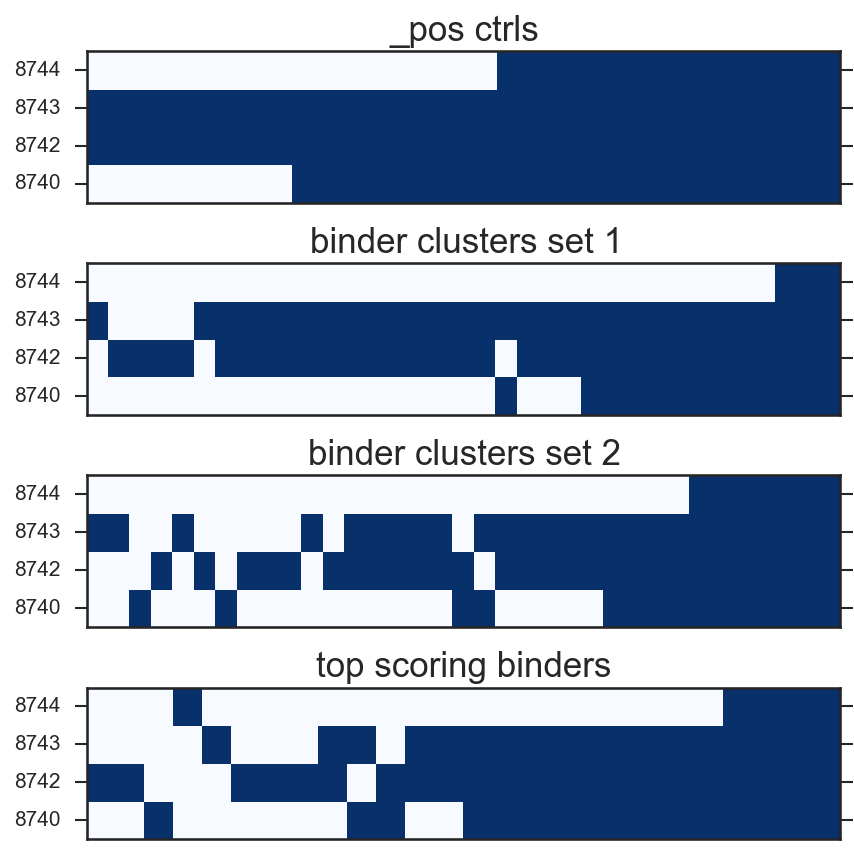

In [7]:
x = wb.copy()
x = x.replace({'-': 0, 'positive': 1})
methlabels = {'cl_tepitopepan': 'binder clusters set 1', 'cl_netmhciipan':'binder clusters set 2',
              'topsharedbinders': 'top scoring binders'} # 'random binders': 'C'}
x['strategy'] = x.method.replace(methlabels)
responsesheatmap(x, cols=wbcols)
plt.savefig('wb_responses_heatmap.png')

### VLA pbmc results:

In [8]:
#pbmc data already has wb positives column in it
pbmc = pd.read_csv('vla_pbmc_results.csv')
pcols = ['7010','7447','7448','7855','7853','7852','7449']
x = pbmc[pcols]
#derive positive rates for each peptide using gareth method of nil mean+3SD and 0.1 cutoff
#nil wells for cutoffs
nil = pd.read_csv('vla_pbmc_nil.csv')

pcut = nil.mean()+nil.std()*3+0.1
pcut2 = nil.mean()+0.1
#pbmcpos = ((x>=pcut) & (x>=pcut2)).astype(int)
#pbmcpos = ((x>=pcut+0.1)).astype(int)
#pbmcpos['method'] = res.method
#responsesheatmap(pbmcpos, cols=pcols)

pbmc['#pbmcpos'] = x[(x>=pcut)].count(1)
#pbmc.plot('#garethpos','#pbmcpos',kind='scatter', figsize=(3,3))

#pbmc['mean'] = pbmc[pcols].mean(1)
#pbmc['#wbpos'] = pbmc['#wbpos']/4*100
#pbmc['#pbmcpos'] = pbmc['#pbmcpos']/7*100
#pbmc['#pbmcpos'] = pbmc['#pbmcpos'].astype(int)
pbmc = pbmc.sort_values('#pbmcpos')

#get the mean fraction of both positive counts
#pbmc['score'] = (pbmc['#pbmcpos']+pbmc['#wbpos'])/2.0
#pbmc['score'] = pbmc.score.round(0)

#just get the total fraction of positives
pbmc['score'] = ((pbmc['#pbmcpos']+pbmc['#wbpos'])/11*100).round(0)

tags = pbmc.tag.apply( lambda x: pd.Series(x.split('_')))
#pbmc['mbname'] = tags[0]
pbmc['id'] = tags[1].astype(int)

#merge with peptide list
plist = pd.read_csv('peptide_lists.csv',index_col=0)
pbmc = plist.merge(pbmc,left_index=True,right_on='id',how='right')
pbmc.ix[pbmc.method.isnull(), 'method'] = '_pos ctrls'
print pbmc.groupby('method').agg({'id':np.size})

#pbmc = pbmc[pbmc.method!='_pos ctrls']
#responsesbreakdown(r, key='#pbmcpos', label='% positives')

ctrls = pbmc[pbmc.method=='_pos ctrls']
print ctrls[['tag','#pbmcpos','#wbpos','score']]
print ctrls.groupby('#pbmcpos').agg({'id':np.size}).T
print 
print 'mean score of positive controls:', ctrls.score.mean()

                  id
method              
_pos ctrls        12
cl_netmhciipan    88
cl_tepitopepan    88
topsharedbinders  94
               tag  #pbmcpos  #wbpos  score
0      CFP10.1_300         1       2     27
1      CFP10.2_301         1       2     27
11  ESAT-6 p55_311         3       4     64
3      CFP10.8_303         3       2     45
8   ESAT-6 p51_308         3       4     64
7   ESAT-6 p47_307         4       3     64
4      CFP10.9_304         4       4     73
6   ESAT-6 p46_306         4       3     64
10  ESAT-6 p53_310         4       4     73
9   ESAT-6 p52_309         4       4     73
5   ESAT-6 p45_305         5       4     82
2      CFP10.7_302         5       3     73
#pbmcpos  1  3  4  5
id        2  3  5  2

mean score of positive controls: 60.75


### data plots

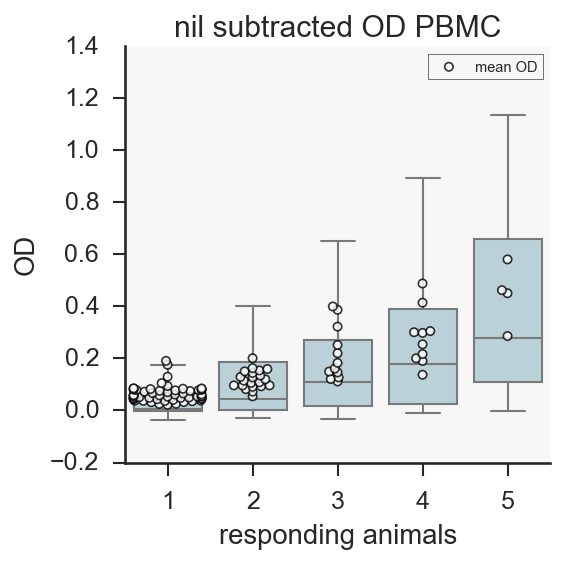

In [9]:
#pbmc data plot
sns.set_context("notebook", font_scale=1.2)
c=['#pbmcpos']+pcols
#subtract nil mean
x = pbmc[pbmc['#pbmcpos']>=1]
x = x[x.method!='_pos ctrls']
x[pcols] = x[pcols]-nil.mean()
#x['numpos'] = (x['#pbmcpos']*7/100+1).astype(int)
x['numpos'] = x['#pbmcpos']
x['mean'] = x[pcols].mean(1)

t = pd.melt(x,id_vars=['numpos','method'],value_vars=pcols,var_name='animal',value_name='OD')

fig,ax = plt.subplots(1,1,figsize=(4,4))
sns.swarmplot(x="numpos", y="mean", data=x,
            alpha=0.8, size=4, linewidth=.8, edgecolor="black", color='white', ax=ax) #jitter=True

ax.legend(['mean OD'],fontsize=7)
sns.boxplot(x="numpos", y="OD", data=t, ax=ax, linewidth=1, saturation=0.5,
           fliersize=0 ,color='lightblue')
ax.set_ylim(-0.2,1.4)
ax.set_xlabel('responding animals')
plt.title('nil subtracted OD PBMC')
plt.tight_layout()
sns.despine()
plt.savefig('oddata_pbmc.png',dpi=300)

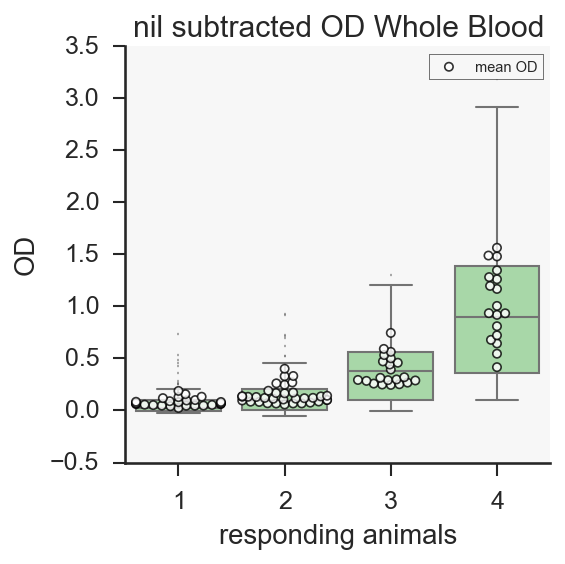

In [10]:
#whole blood data plot
#whole blood values already nil subtracted

wb = pd.read_csv('vla_wholeblood_results.csv')
wb = wb.sort_values('#pos')
cols = ['8740_val','8742_val','8743_val','8744_val']
wb['mean'] = wb[cols].mean(1)

x = wb[wb['#pos']>=1]
x = x[-x.tag.isin(ctrls.tag)]
x['#pos'] = wb['#pos']

t = pd.melt(x,id_vars='#pos',value_vars=cols,var_name='animal',value_name='OD')

fig,ax = plt.subplots(1,1,figsize=(4,4))
sns.swarmplot(x="#pos", y="mean", data=x, #hue='animal', palette='Set1', jitter=True,
            alpha=0.8, size=4, linewidth=.8, edgecolor="black", color='white', ax=ax)
ax.legend(['mean OD'],fontsize=7)
sns.boxplot(x="#pos", y="OD", data=t, ax=ax, linewidth=1, saturation=0.5,
           fliersize=1 ,color='lightgreen')
plt.title('nil subtracted OD Whole Blood')
ax.set_xlabel('responding animals')
plt.tight_layout()
sns.despine()
plt.savefig('oddata_wb.png',dpi=300)

### pbmc results for baseline/control set

In [11]:
pbmcbl = pd.read_csv('vla_pbmc_baseline.csv')
x = pbmcbl[pcols]

#nil wells for cutoffs
nil = pd.read_csv('vla_pbmc_nil_baseline.csv')
blcut = nil.mean()+nil.std()*3+0.1
blcut2 = nil.mean()+0.1
pbmcbl['#pbmcpos'] = x[(x>=blcut)].count(1)
#pbmcbl['#pbmcpos'] = pbmcbl['#pbmcpos']/7*100
#pbmcbl['#pbmcpos'] = pbmcbl['#pbmcpos'].astype(int)
pbmcbl['score'] = (pbmcbl['#pbmcpos']/7*100).round(0)

pbmcbl.rename(columns={'method':'predictor'})

neglist = pd.read_csv('negatives_list.csv',index_col=0)
neglist = neglist.drop(['score'],axis=1)
pbmcbl = neglist.merge(pbmcbl,on='id')
print len(pbmcbl)
pbmcbl['method'] = 'random binders'

94


### create a final dataframe with all results

In [12]:
final = pd.concat([pbmc,pbmcbl])

#calculate final confidence levels by binning score based on positive controls
bins = [0,26,100]
final['confidence'] = pd.cut(final.score, bins=bins, precision=0, include_lowest=True,
                             labels=['low','high'])
#create column label combining cluster methods
methlabels = {'cl_tepitopepan': 'Binder Clusters', 'cl_netmhciipan':'Binder Clusters',
              'topsharedbinders': 'Top Scoring Binders', 'random binders': 'Random Binders (Control)'}    
final['strategy'] = final.method.replace(methlabels)

final = final.drop(['tbname','translation','product','name','nearest','allele','1-log50k(aff)','core','order',
                    'plate_no','#garethpos','rank','pos','source','length'],axis=1)
#print final[:2]
import csv
final.to_csv('final_results_all.csv', quoting=csv.QUOTE_NONNUMERIC)
#print final.ix[0]
print
print final.groupby('method').size()
print final.groupby(['method','confidence']).size().T
#print

#s2 = responsesbreakdown(final, key='#pbmcpos', label='% pbmc positives')
#plt.savefig('responses_bymethod_pbmc.png')
#s2.cumsum().sum()
#s2['%pos'] = s2[s2.columns[-4:]].sum(1)/s2.sum(1)*100
#s2 = s.merge(s2,left_index=1,right_index=1,how='right').fillna(0)
#display(s2)



method
_pos ctrls          12
cl_netmhciipan      88
cl_tepitopepan      88
random binders      94
topsharedbinders    94
dtype: int64
method            confidence
_pos ctrls        high          12
cl_netmhciipan    low           60
                  high          28
cl_tepitopepan    low           68
                  high          20
random binders    low           92
                  high           2
topsharedbinders  low           76
                  high          18
dtype: int64


### pbmc responses breakdown

In [ ]:
#get boolean arrays for heatmap by subtracting cuts

xfinal = (final[pcols]>=pcut).astype(int)
xfinal['method'] = final.method
xbl = (pbmcbl[pcols]>=blcut).astype(int)
xbl['method'] = 'baseline'
xctrls = (ctrls[pcols]>=pcut).astype(int)
xctrls['method'] = '_pos ctrls'
xcomb = pd.concat([xfinal,xbl,xctrls])

responsesheatmap(xcomb, cols=pcols)
plt.savefig('pbmc_responses_heatmap.png')

/usr/local/lib/python2.7/dist-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


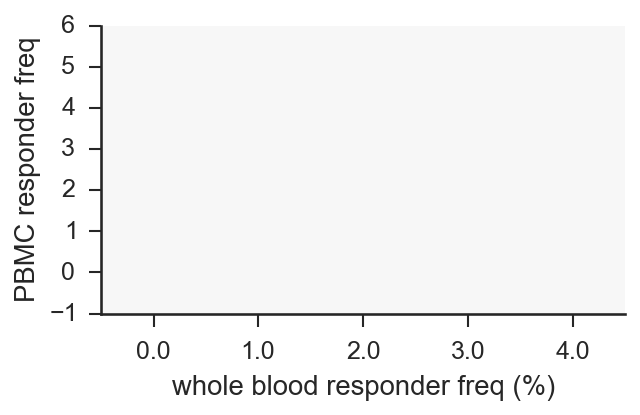

In [13]:
final = pd.read_csv('final_results_all.csv')
final = final.replace('_pos ctrls','positive controls')
final = final.sort('#wbpos')
g=sns.factorplot(x='#wbpos',y='#pbmcpos',data=final,kind='swarm',size=3,marker='x',#jitter=True,
                 aspect=1.5,alpha=.6,edgecolor='black')
ax=g.axes.flatten()[0]
#g=sns.factorplot(x='#wbpos',y='#pbmcpos',data=final,kind='box',size=3,aspect=1.5,ax=ax)
ax.set_xlabel('whole blood responder freq (%)')
ax.set_ylabel('PBMC responder freq')

### final breakdown of combined responses

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


confidence,high,low,success
strategy,,,
Binder Clusters,48,128,27.272727
Random Binders (Control),2,92,2.127660
Top Scoring Binders,18,76,19.148936


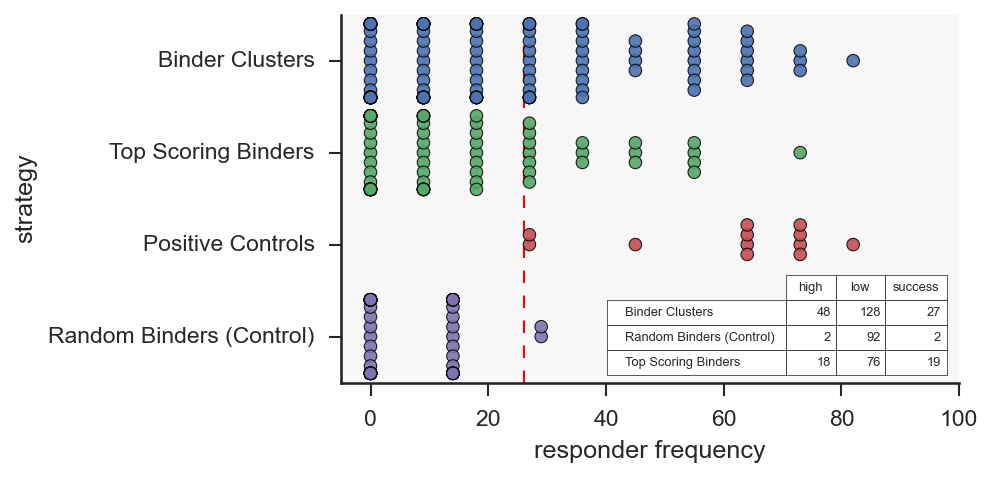

In [14]:
sns.set_context("notebook", font_scale=1.1)
#final.hist('score',by='method',stacked=True,figsize=(5,3),sharex=True,bins=range(0,100,5))
final = pd.read_csv('final_results_all.csv')
final = final.replace('_pos ctrls','Positive Controls')
#custom sort 
names = {'Binder Clusters':0, 'Top Scoring Binders':1,'Positive Controls':2,'Random Binders (Control)':3}

final['order'] = final.strategy.map(names)
final=final.sort_index(by='order')
final=final.drop('order',1)
x = final[-final.method.isin(['Positive Controls'])]
#print x[x.method=='random binders'][['confidence','score']]

sf = x.groupby(['confidence','strategy']).agg({'id':np.size})
sf = sf.unstack('strategy')
sf.columns = sf.columns.get_level_values(1)
perc = sf.sum(1)
sf = sf.T.fillna(0)

'''sf['order'] = sf.index.to_series().map(names)
sf=sf.sort_index(by='order')
sf=sf.drop('order',1)'''

sf['success'] = sf['high']/sf.sum(1)*100
#hydroplot(final, key='confidence')
display(sf)
#from statsmodels.stats.weightstats import ztest

g=sns.factorplot(y='strategy',x='score',data=final,kind='swarm',s=6,#size=4,
                 aspect=1.7,alpha=.9,edgecolor='black',linewidth=.5)
ax=g.axes.flatten()[0]
ax.set_xlabel('responder frequency')
#ax.set_xticks(x.score.unique())
#for i in ax.get_xticklabels():
#    i.set(rotation=90)

ax.axvline(26,0,100,linewidth=1, color='red',linestyle='--')    
#g.fig.text(.7, 1.0, 'positive', bbox={'facecolor':'white','alpha':0.8, 'pad':5})
#g.fig.text(.4, 1.0, 'negative', bbox={'facecolor':'white','alpha':0.8, 'pad':5})
ax.set_xlim((-5,100))
sns.despine()
plt.subplots_adjust(top=0.8)
from pandas.tools.plotting import table
t=table(ax, sf.astype(int),loc='lower right',colWidths=[0.08, 0.08, 0.1])
#t.auto_set_font_size(False)
#t.set_fontsize(5.8)
#plt.tight_layout()

plt.savefig('responder_freqs_stripplot.png',bbox_inches='tight',dpi=300)
    

### look at top peptide and shared binders

In [15]:
final = pd.read_csv('final_results_all.csv')
#top peptides (high confidence) and their protein info
cols = ['locus_tag','mbname','peptide','method','strategy','score','confidence','start']

top = final[final.confidence=='positive']
top = top[top.method != '_pos ctrls']
neg = final[final.confidence=='negative']

#overlap of our final sets with known antigens
EpitopePipeline=reload(EpitopePipeline)
antigens = EpitopePipeline.getAntigenDatasets()
antigens['source'] = antigens.source.apply(lambda r: ';'.join(r))
top = antigens.merge(top[cols],on='locus_tag',how='right')

annot = EpitopePipeline.combineAnnotationData()
#kruh = pd.read_csv('Kruh_proteome_30d.csv')
#print top[top.locus_tag.isin(kruh.locus_tag)]
#add annotations
top = top.merge(annot[['locus_tag','gene','length','product']],on='locus_tag',how='left')
top = top.sort_values(['score','locus_tag'],ascending=[False,True]).fillna('')
top = top.reset_index(drop=True)
top.to_csv('top_peptides.csv',index=False)

print '%s peptides in positive category' %len(top)
print 'total positive rate: %s' %str(len(top)/270.0)
print

#print top.columns
topc = top.groupby('locus_tag').agg({'peptide':np.size,
                                     'product':base.first}).sort_values('peptide',ascending=False)
topc = topc.rename(columns={'peptide':'positives'})
#print topc[:5]

tsp = final.groupby('locus_tag').agg({'strategy':base.first,'R':np.size})
tsp = tsp.rename(columns={'R':'prots'})

#lt=['Rv0655']
#lt=['Rv3676','Rv3584']
#lt='Rv0757'
lt=['Rv3584']
display(final[final.locus_tag.isin(lt)][cols].sort_values(['locus_tag','start']))

print 'proteins with most positives:'
x = tsp.merge(topc,left_index=True,right_index=True)
x = x[x.positives>1].sort_values(['positives','strategy'],ascending=False)
display(x)
#print x.groupby('prots').agg({'positives':np.sum})
#x['frac'] = x.peptide/x.prots
#x.plot('prots','frac',kind='scatter',figsize=(4,4))
print 'peptides with highest scores:'
display( top[top.score>=60][cols])

0 peptides in positive category
total positive rate: 0.0



,locus_tag,mbname,peptide,method,strategy,score,confidence,start
187,Rv3584,Mb3615,AVNGNRLTINNVLLRDIRIQ,topsharedbinders,Top Scoring Binders,36,high,43
168,Rv3584,Mb3615,LTINNVLLRDIRIQAVQTSD,topsharedbinders,Top Scoring Binders,27,high,49
185,Rv3584,Mb3615,PGKAVDLVLVAVNQSPDVSD,topsharedbinders,Top Scoring Binders,9,low,72


proteins with most positives:


,prots,strategy,product,positives


peptides with highest scores:


,locus_tag,mbname,peptide,method,strategy,score,confidence,start


260 260


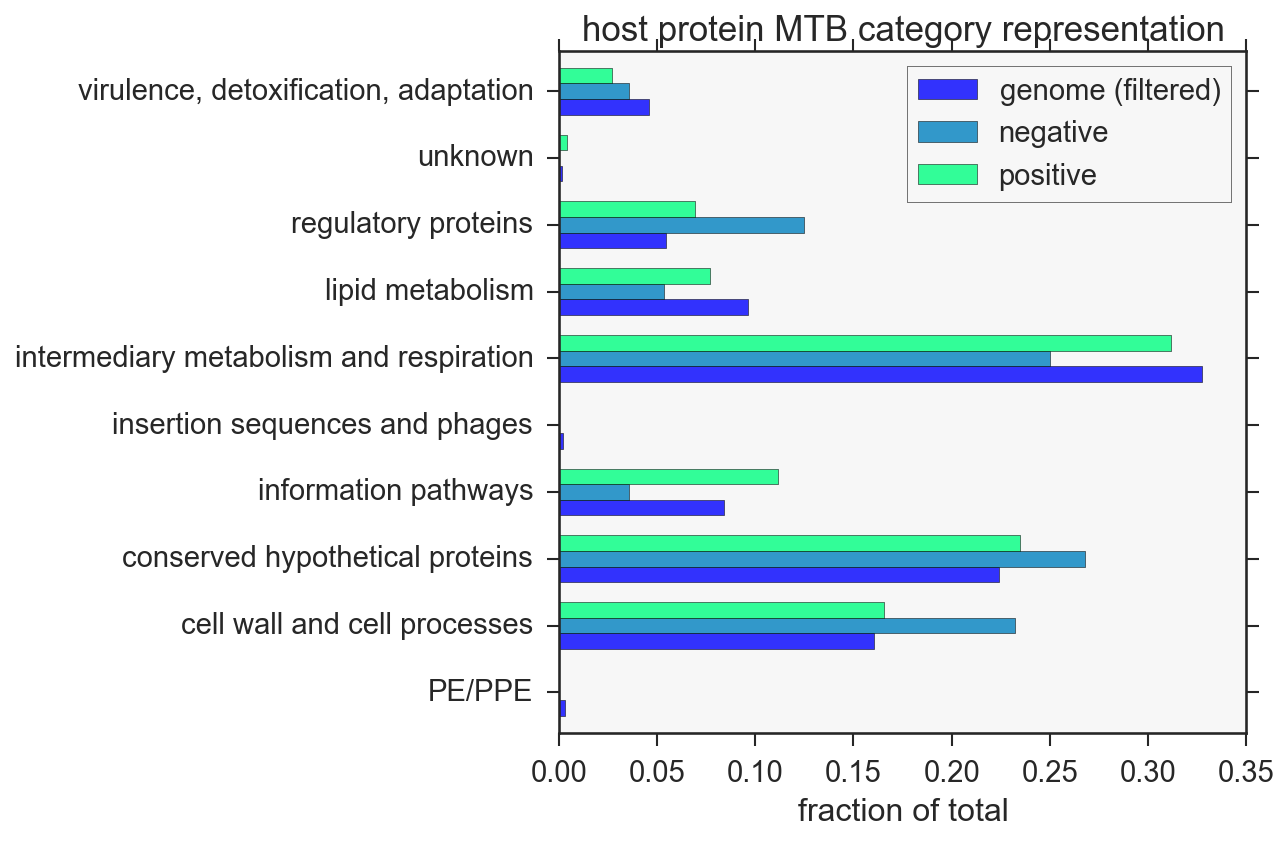

In [40]:
#cg = EpitopePipeline.getCategories(genome,plot=False)
cg = EpitopePipeline.getCategories(srm,plot=False)

cneg = EpitopePipeline.getCategories(neg,plot=False)
cpos = EpitopePipeline.getCategories(top,plot=False)

print len(neg), cneg.sum()

cats = pd.concat([cg,cpos,cneg],axis=1)
cats = cats/cats.sum()
cats.columns=(['genome (filtered)','negative','positive'])
ax=cats.plot(kind='barh',cmap='winter',alpha=0.8,width=.7,grid=False,figsize=(9,6))
plt.xlabel('fraction of total')
ax.set_title('host protein MTB category representation')
plt.tight_layout()
plt.savefig('vlaresults_cats.png')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f20c0bdab10>], dtype=object)

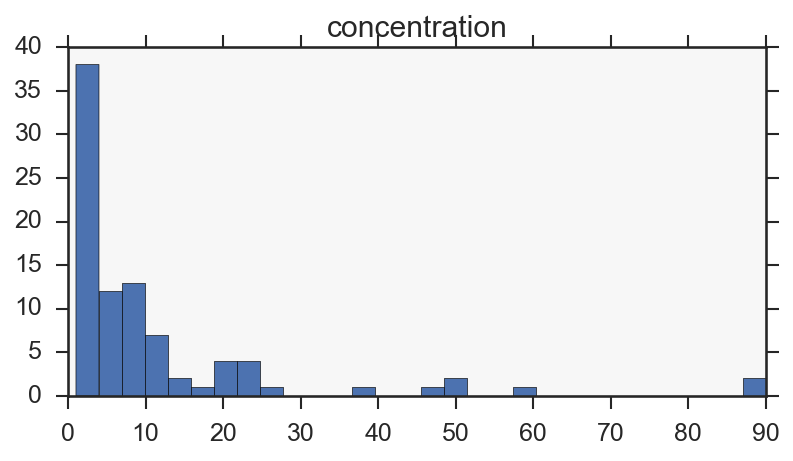

In [17]:
#srm concentrations of positives?
c = top.merge(srm, on='locus_tag', how='left')
f,ax=plt.subplots(1,1,figsize=(6,3))
c.hist('concentration',bins=30,ax=ax,grid=False)
#ax.set_yscale('log')
#print c[c['concentration_y']>10][['locus_tag','concentration_y','score','product_y']]

Index([u'Unnamed: 0', u'#garethpos', u'#pbmcpos', u'#wbpos', u'1-log50k(aff)', u'7010', u'7447',
       u'7448', u'7449', u'7852', u'7853', u'7855', u'8740', u'8742', u'8743', u'8744', u'R',
       u'RVL', u'allele', u'binders', u'clustersize', u'concentration', u'core', u'end', u'gene',
       u'hydro', u'id', u'id_x', u'id_y', u'identity', u'iedbmhc1_11_overlap',
       u'iedbmhc1_9_overlap', u'length', u'locus_tag', u'mbname', u'mean', u'method',
       u'mhc1overlaps', u'name', u'nearest', u'order', u'overlap', u'pep_no', u'peplength',
       u'peptide', u'pos', u'product', u'rank', u'score', u'source', u'start', u'tag', u'tbname',
       u'translation', u'wbmean', u'well_no', u'confidence'],
      dtype='object')


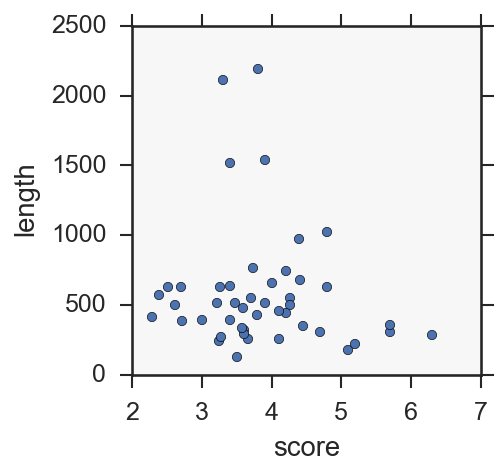

In [18]:
#clusters correlation with positives and no. binders..?
f=pd.read_csv('final_results_all.csv')
print f.columns
f.plot('score','length',kind='scatter',figsize=(3,3))

#tsb correlation with binders in each epitope R?..


### mhc1 overlaps and positives

overlap  method          
0        random binders      31
         topsharedbinders    46
1        cl_netmhciipan      88
         cl_tepitopepan      88
         random binders      63
         topsharedbinders    48
dtype: int64
                mean       std  size
confidence                          
negative    1.692308  1.523794   260
positive    2.125000  1.629975    56


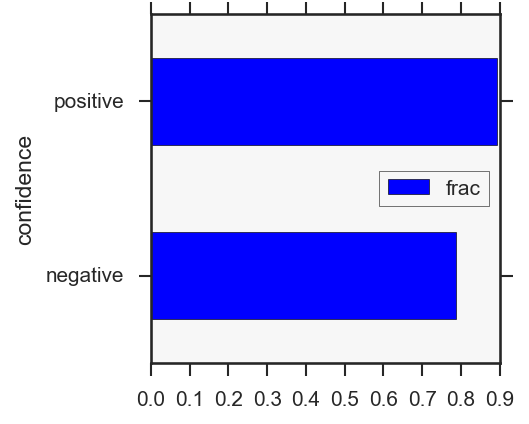

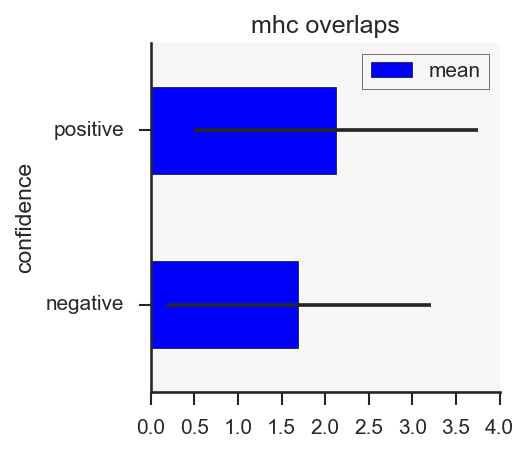

In [78]:
f=pd.read_csv('final_results_all.csv')
#f['confidence'] = f.confidence.map({'negative':0,'low':1,'medium':2,'high':3})
f['confidence'] = pd.Categorical(f.confidence)
sns.set_context("notebook", font_scale=1.0)
#f = f[f.method.isin(['topsharedbinders'])]
#f['mhc1overlaps'] = f.filter(regex="iedbmhc1_").sum(axis=1)
f['overlap'] = (f.mhc1overlaps>=1).astype(int)

xx = f[-f.mhc1overlaps.isnull()]
cols=['peptide','method','iedbmhc1_9_overlap','iedbmhc1_11_overlap','overlap']
#print xx[cols][22:34]

print xx.groupby(['overlap','method']).size()

gg = xx.groupby(['confidence']).agg({'overlap': [np.sum,np.size]})
gg.columns = gg.columns.get_level_values(1)
gg['frac'] = gg['sum']/gg['size']
#print gg

#gg.plot(y='overlap',kind='barh',by='overlap',figsize=(3,3))
gg.plot(y='frac',kind='barh',figsize=(3,3))


#xx.plot('mhc1overlaps','confidence',kind='scatter',figsize=(2,2))
gg = xx.groupby(['confidence']).agg({'mhc1overlaps': [np.mean,np.std,np.size]})
gg.columns = gg.columns.get_level_values(1)
print gg
gg.plot(y='mean',xerr='std',kind='barh',figsize=(3,3))
plt.title('mhc overlaps')
sns.despine()
#xx.hist('mhc1overlaps',by='confidence')

### distributions of BoLA alleles

**references:**

* A. B. Dietz, N. D. Cohen, L. Timms, and M. E. Kehrli, “Bovine lymphocyte antigen class II alleles as risk factors for high somatic cell counts in milk of lactating dairy cows.,” J. Dairy Sci., vol. 80, no. 2, pp. 406–412, 1997.
* J. Oprządek, P. Urtnowski, G. Sender, A. Pawlik, and M. Łukaszewicz, “Frequency of BoLA-DRB3 alleles in Polish Holstein-Friesian cattle,” Anim. Sci. Pap. Reports, vol. 30, no. 2, pp. 91–101, 2012.
* R. Baxter, N. Hastings, a. Law, and E. J. Glass, “A rapid and robust sequence-based genotyping method for BoLA-DRB3 alleles in large numbers of heterozygous cattle,” Anim. Genet., vol. 39, no. 5, pp. 561–563, 2008.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: FutureWarning: order is deprecated, use sort_values(...)


name,baxter,dietz,oprzadek
index,,,
*24,-,0.1429,0.207
*08,-,0.141,0.137
*22,-,0.1429,0.1239
*27,0.2,0.0369,-
*11,0.16,0.0851,0.031
*16,0.1,0.1001,0.0752
*23,-,0.091,0.0819
*06,0.06,-,-
*09,0.06,-,-


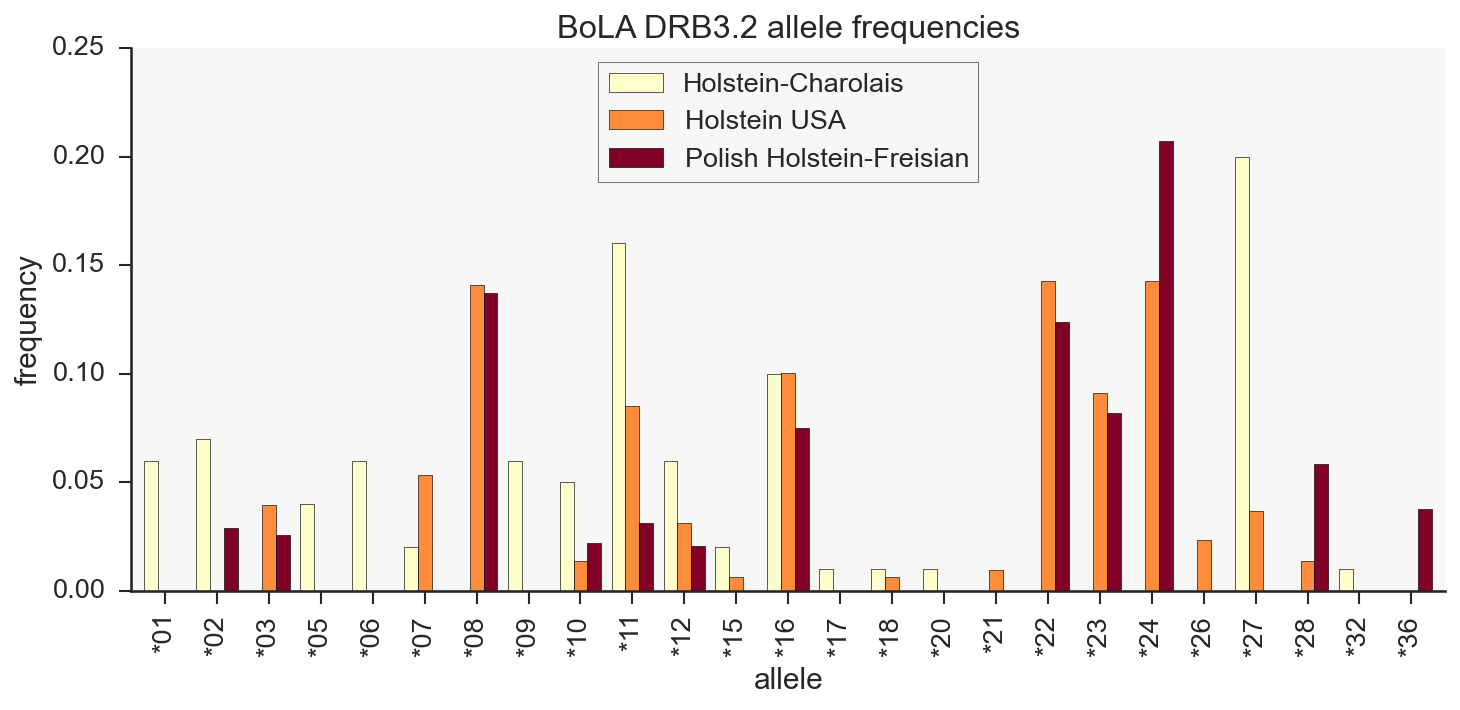

In [24]:
#bola alleles plots
bd = pd.read_csv('bola_alleles_dietz.csv')
bd=bd.set_index('allele').sort('freq',ascending=False)
bd['name'] = 'dietz'

bo = pd.read_csv('bola_alleles_oprzadek.csv')
bo = bo.groupby('allele_short').agg({'freq':np.max})
bo=bo.sort('freq',ascending=False)
bo['name'] = 'oprzadek'

bx = pd.read_csv('bola_alleles_baxter.csv')
bx = bx.groupby('allele_short').agg({'freq':np.max})
bx=bx.sort('freq',ascending=False)
bx['name'] = 'baxter'

x=pd.concat([bd,bo,bx]).reset_index('allele')
x = x.pivot('index','name','freq')
x=x[x>0.005].dropna(how='all')
table = x[x>0.02].reindex_axis(x.mean(1).order(ascending=False).index).dropna(how='all').fillna('-')

sns.set_context("notebook", font_scale=1.3)
x.plot(y=['baxter','dietz','oprzadek'],kind='bar',figsize=(10,5),cmap='YlOrRd',grid=False,width=0.8)
plt.title('BoLA DRB3.2 allele frequencies')
plt.xlabel('allele')
plt.ylabel('frequency')
plt.legend(labels=['Holstein-Charolais','Holstein USA','Polish Holstein-Freisian'],loc=9)
sns.despine()
plt.tight_layout()
plt.savefig('bola_allelefreqs.png')
targetbola = x.index
table

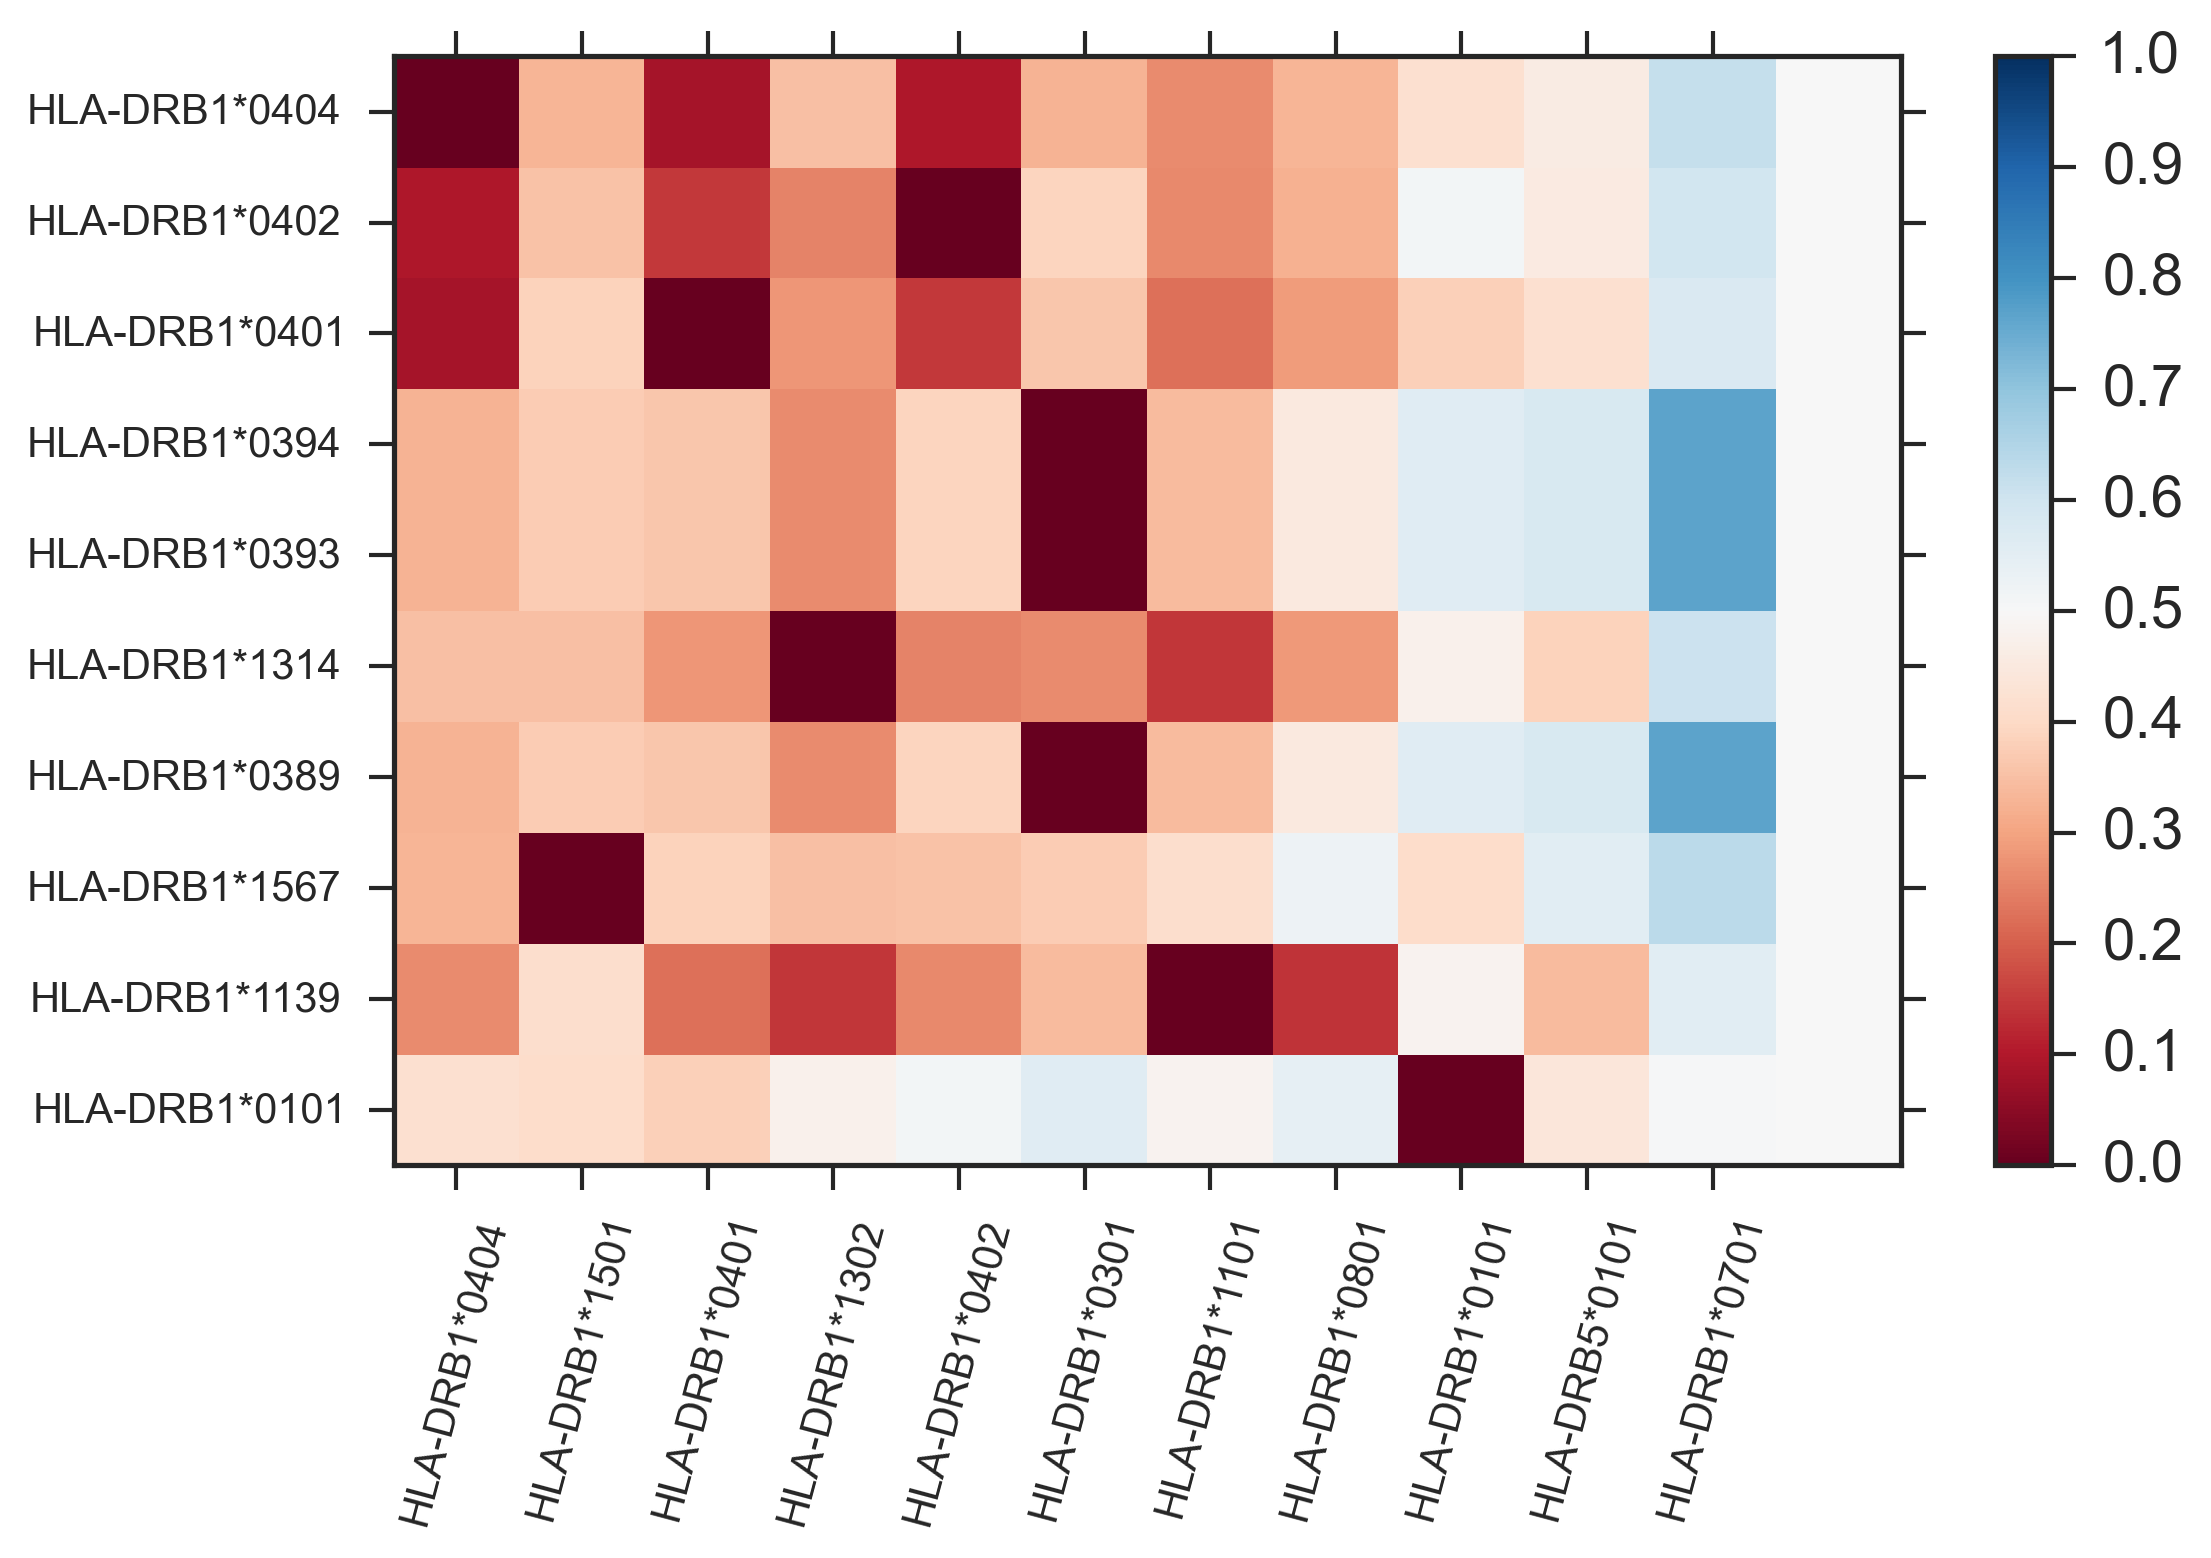

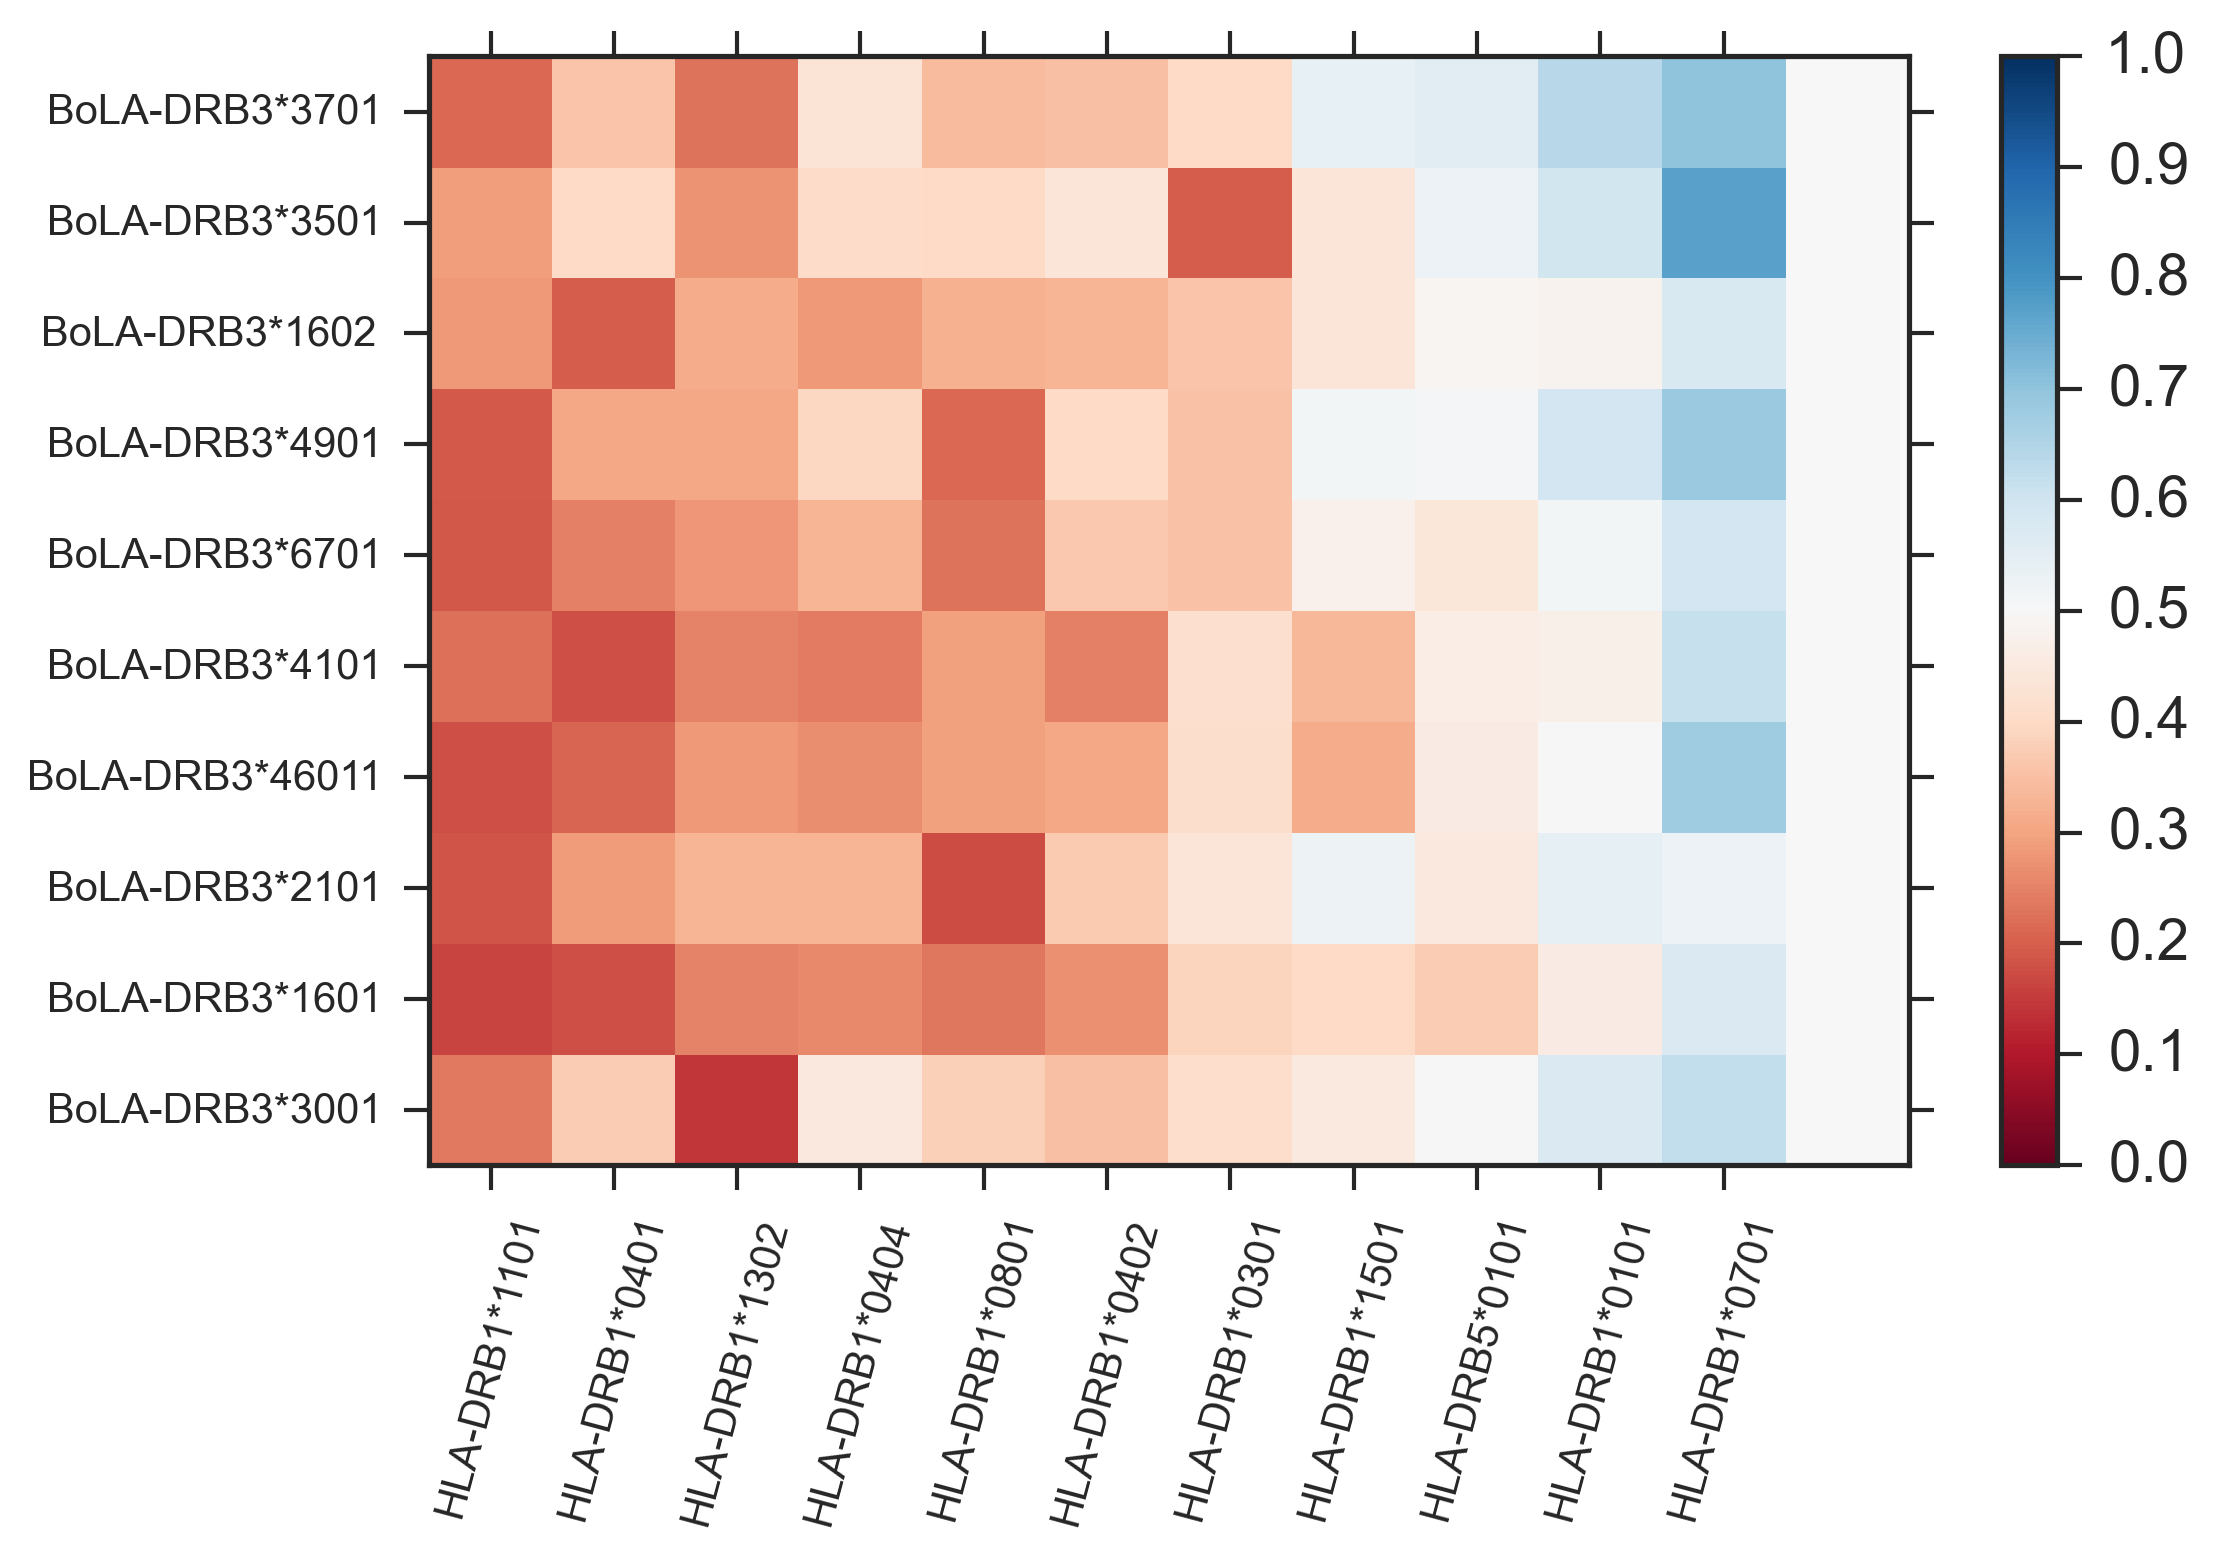

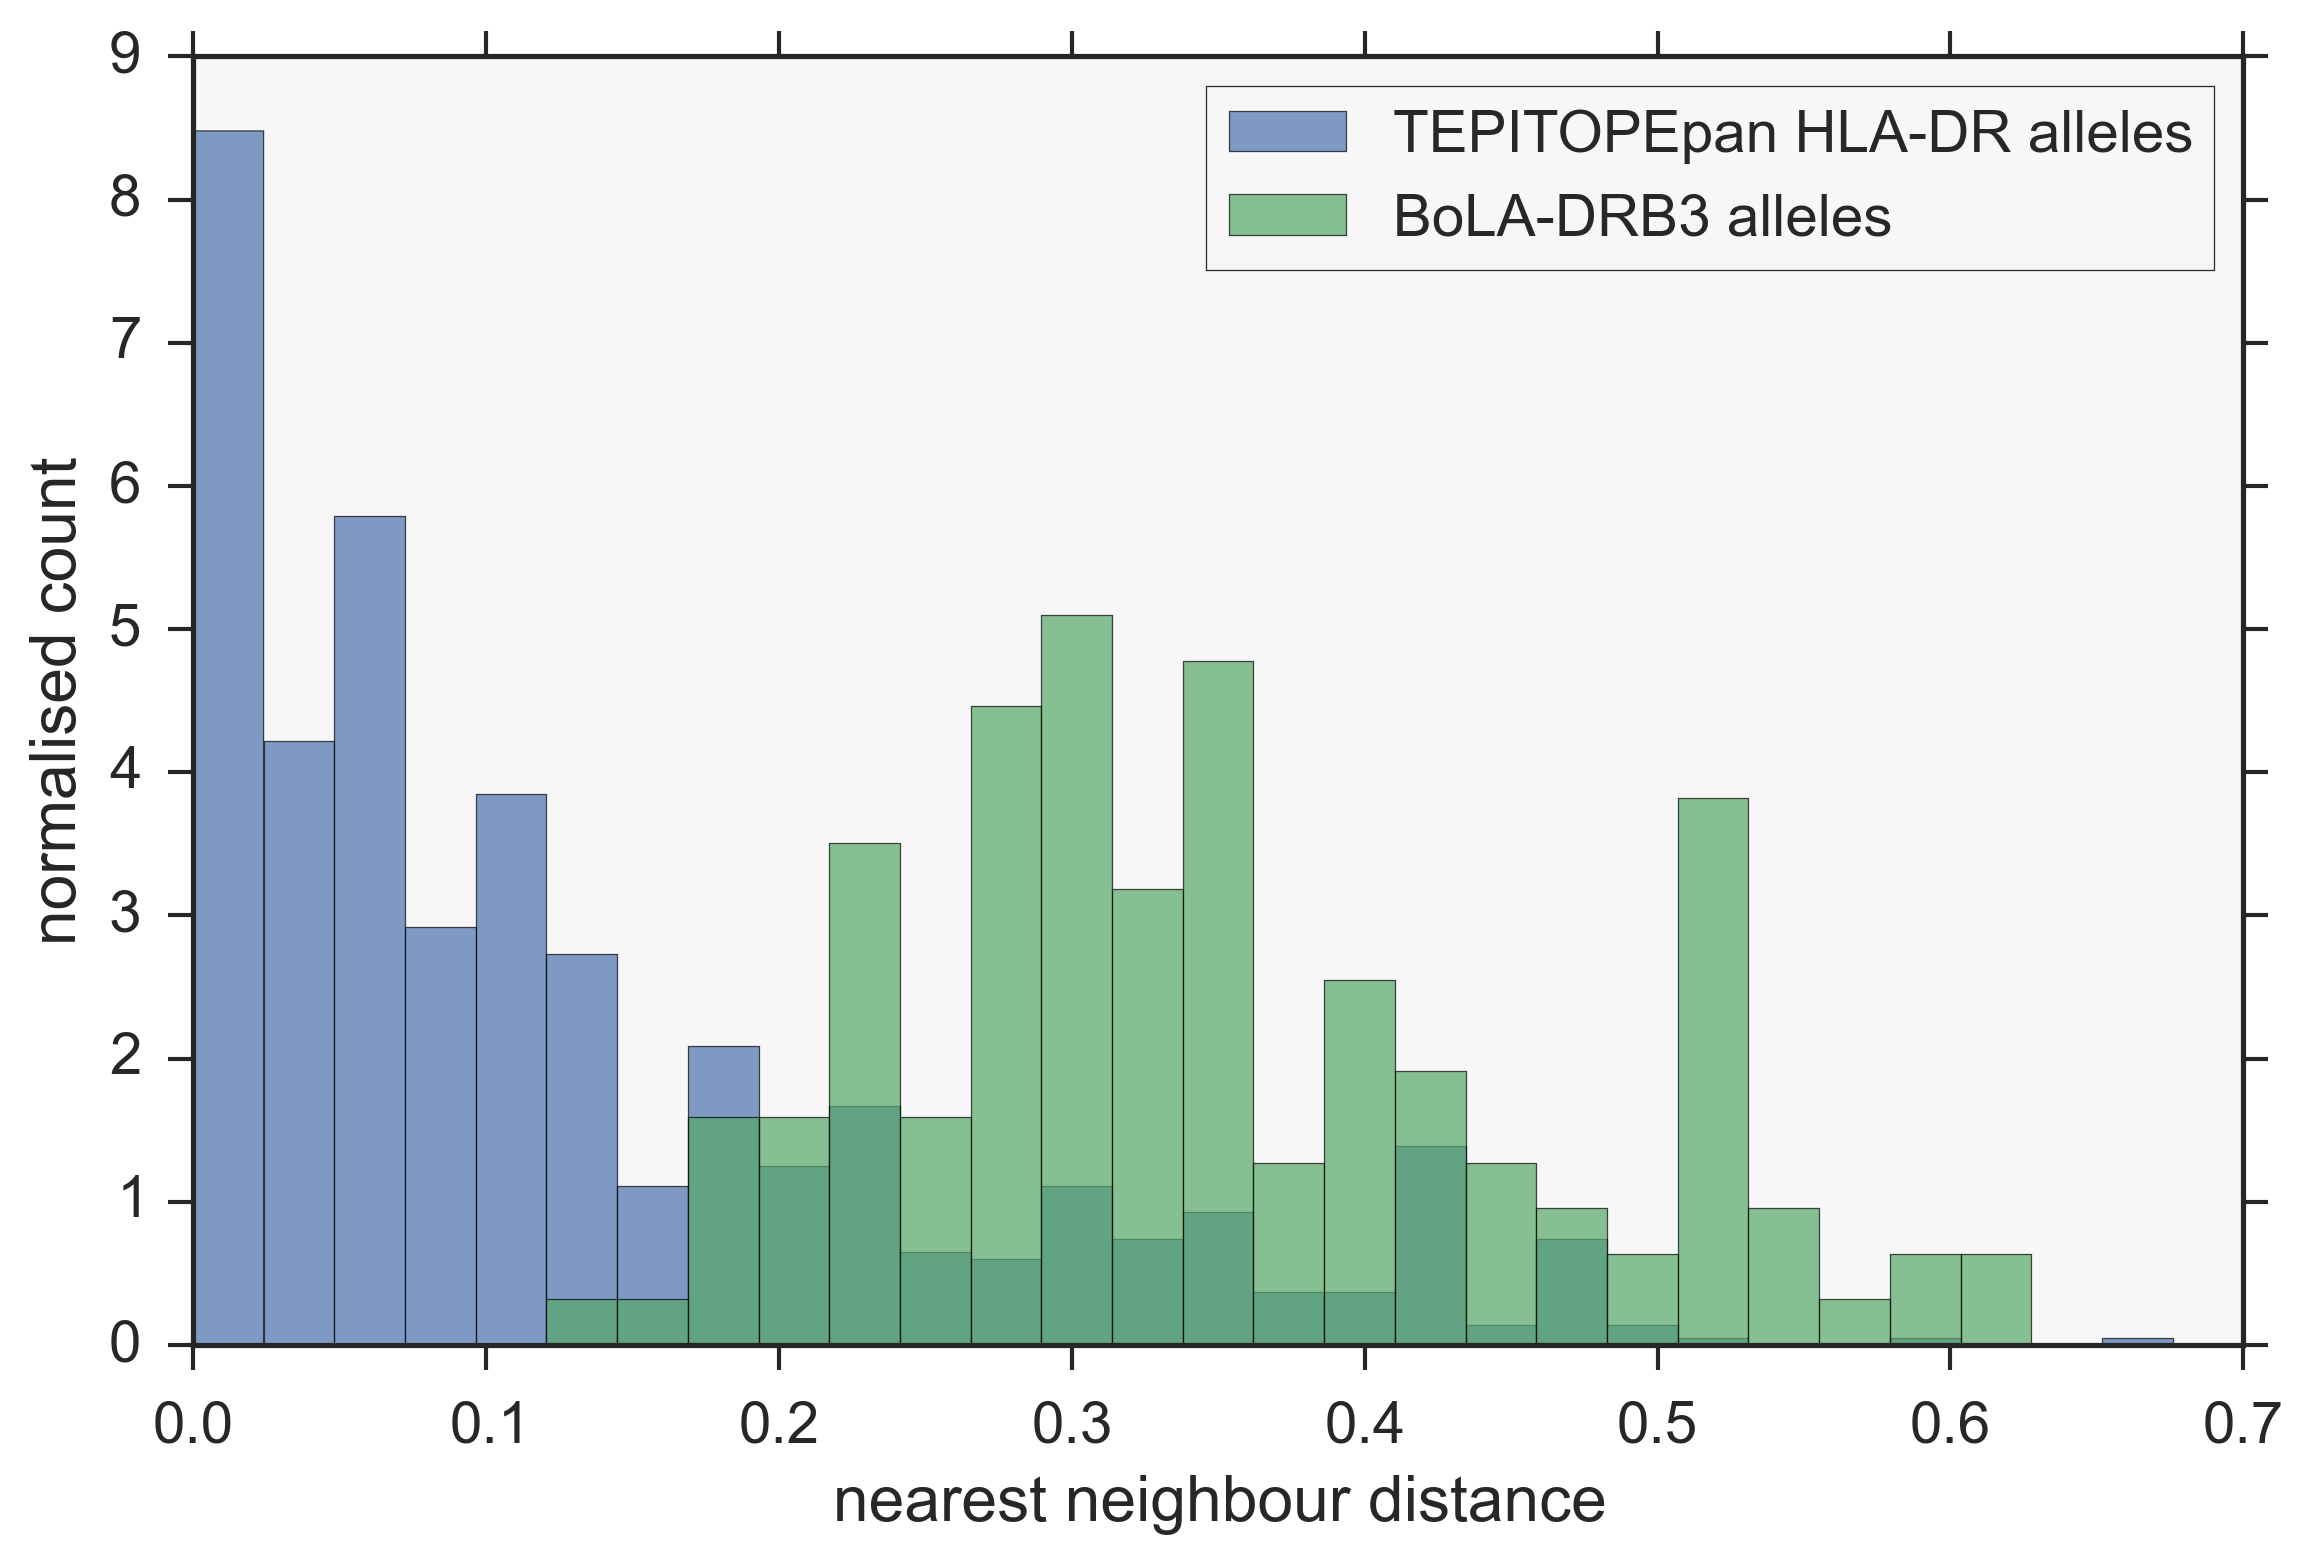

In [29]:
reload(Tepitope)
d=Tepitope.datadir
boladrb = os.path.join(d,'IPD_MHC/bola.drb3.fa')
hladrb = os.path.join(d,'IPD_MHC/hla.drb345.fa')
ref = os.path.join(d,'IPD_MHC/hlaref.fa')
aln = Tepitope.drbaln
alnindex = dict([(a.id,a) for a in aln])
Tepitope.compareRef(hladrb,boladrb,ref,alnindex)


ref
HLA-DRB3*0201    0.158295
nearest          0.160000
HLA-DRB1*1101    0.162258
HLA-DRB1*0801    0.172932
HLA-DRB1*1301    0.173228
HLA-DRB1*0401    0.176024
HLA-DRB1*1401    0.182514
HLA-DRB1*0301    0.198380
HLA-DRB3*0101    0.212574
HLA-DRB1*1601    0.252501
dtype: float64


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


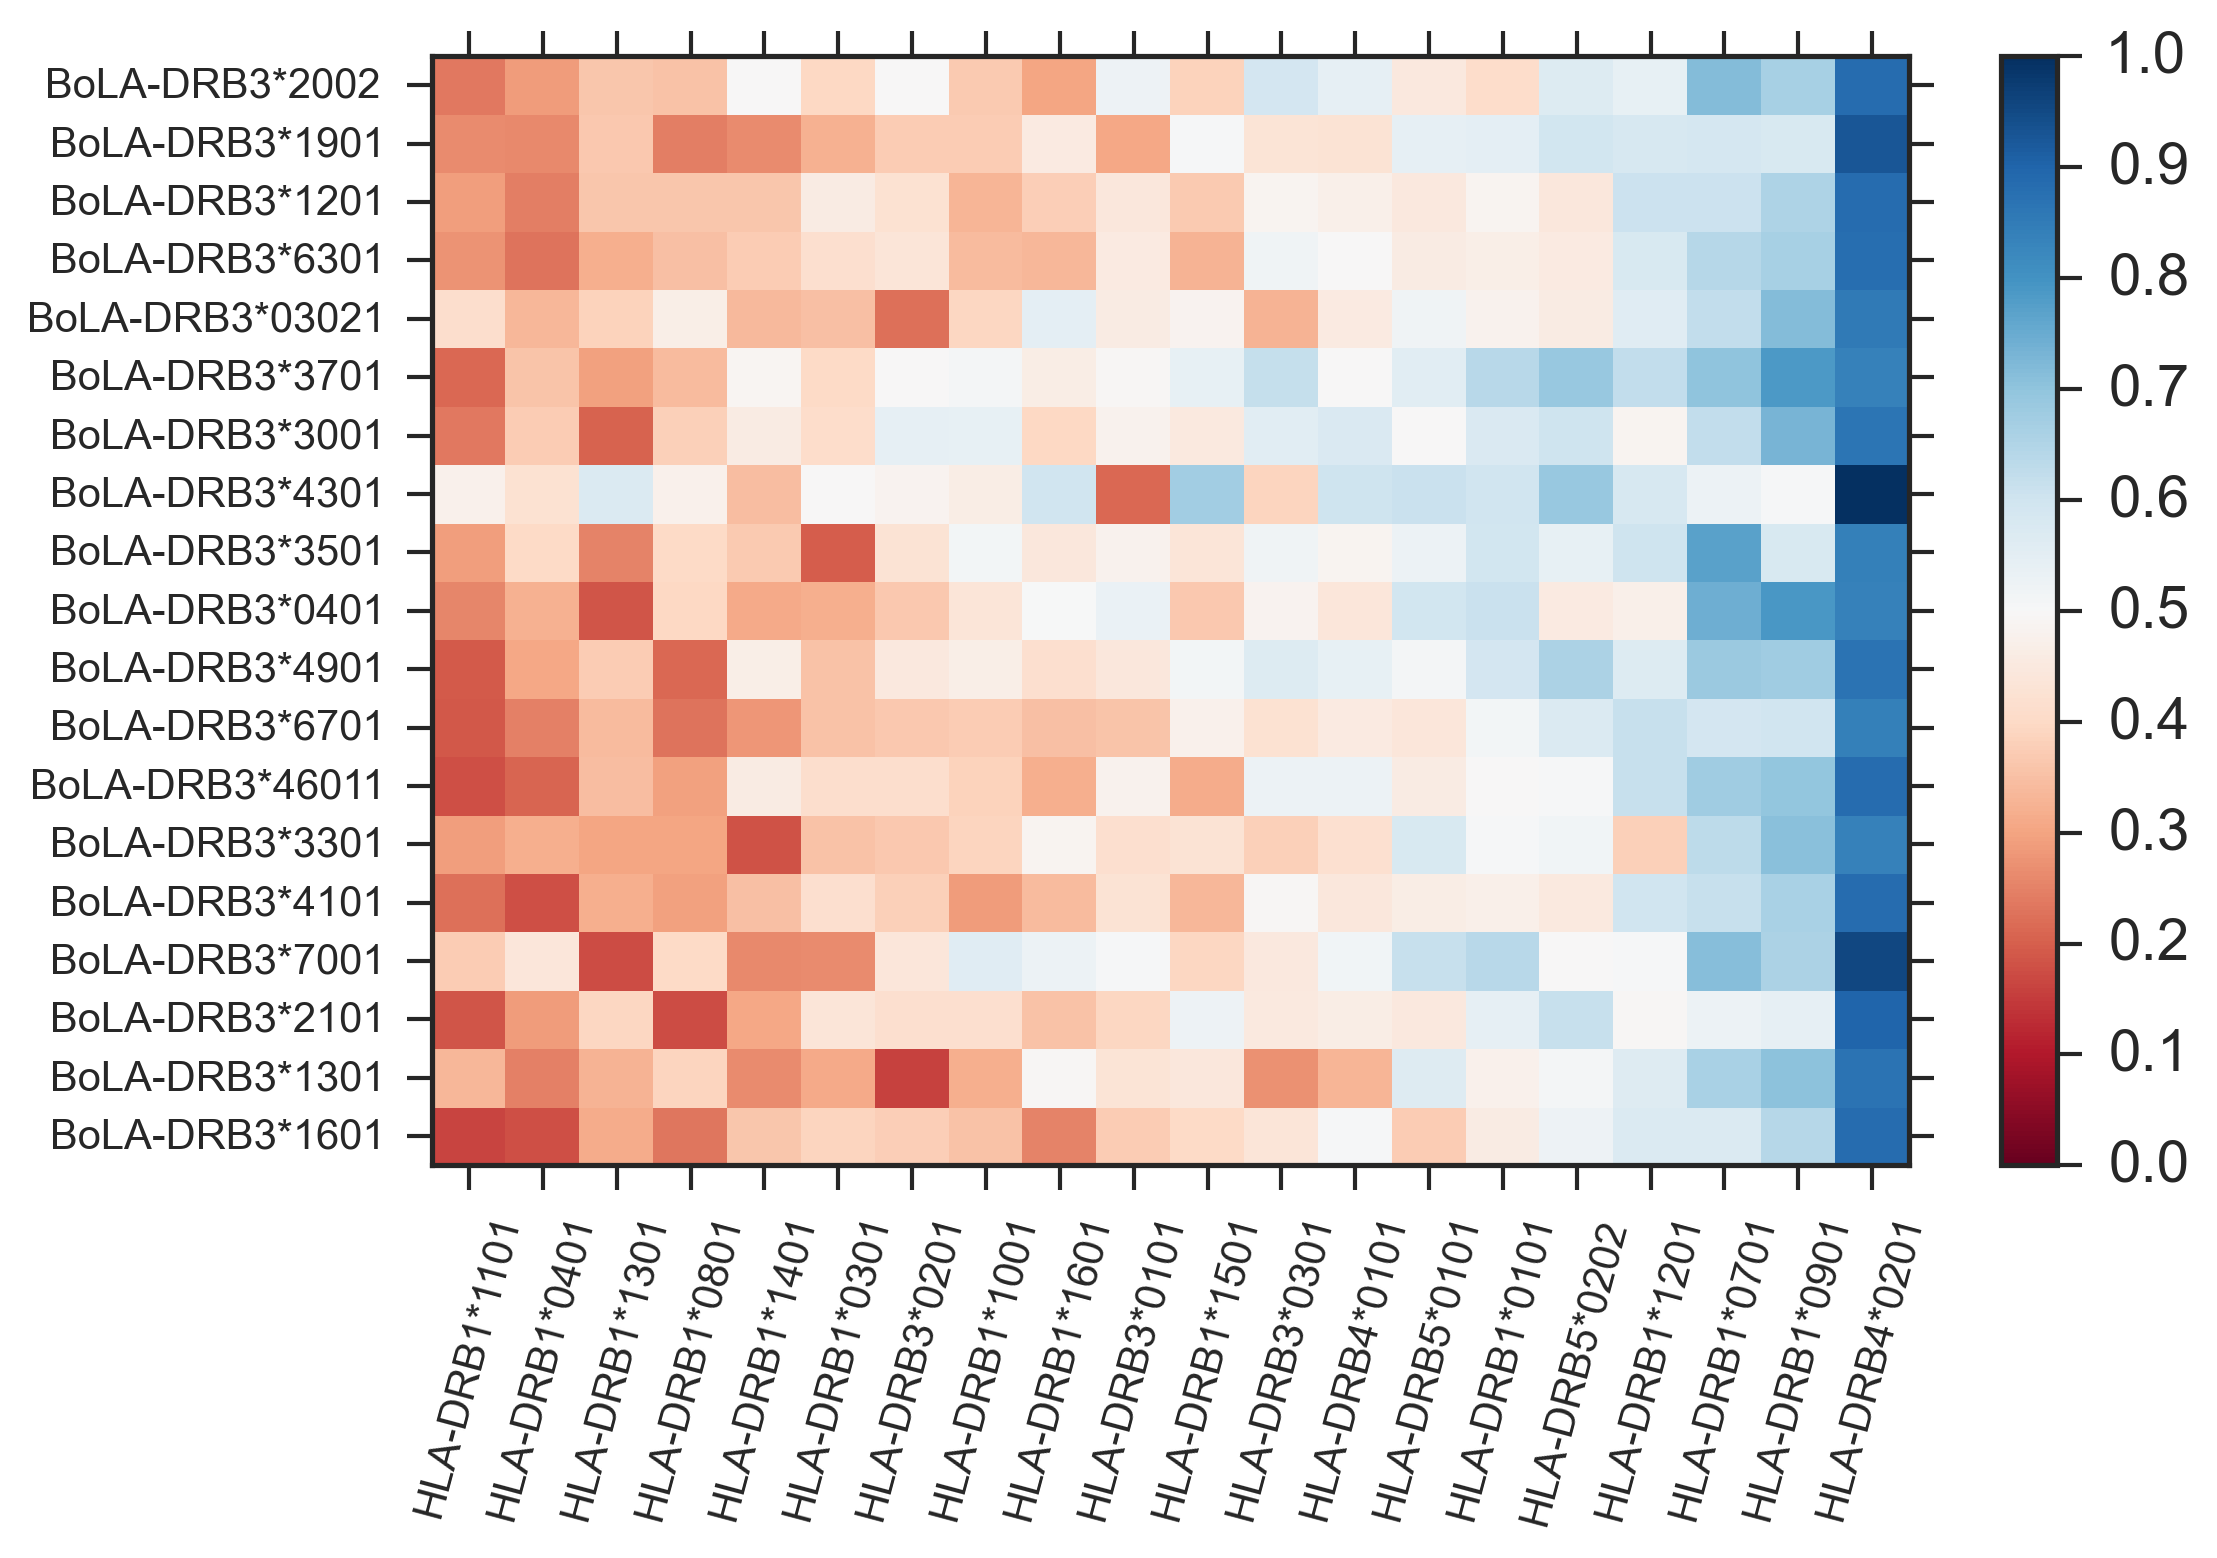

In [30]:
reload(Tepitope)
a = Tepitope.compare(hladrb, boladrb, alnindex)
hlas = a.min()
hlas.sort()
print hlas[:10]

In [118]:
#old vla negatives
gp = pd.read_csv('gareth_negatives.csv')
#how to find epitope ranking in our binders?
#print b1[:10]
#print neg[:2]

def findinGenome(genome, peptide):
    t = genome[genome.translation.str.contains(peptide)]
    if len(t)>0:
        return t.head(1).squeeze().locus_tag
    else:
        return ''
    
gp['locus_tag'] = gp.apply( lambda x: findinGenome(genome, x.sequence), 1)
print gp[:10]

     id              sequence locus_tag
0   BV1  RTTIKRWFPGFMTFRFLECG    Rv0032
1   BV2  MMMHNIQRPTLPDDMSEEFC    Rv0032
2   BV3  MMDIQLHEPTMWKHSPSRSR    Rv0058
3   BV4  PHDWIVWHFTHADNLPGIIT    Rv0059
4   BV5  FVDFDLLCQRQWHNTDDDPN    Rv0059
5   BV6  FDLLCQRQWHNTDDDPNRQS    Rv0059
6   BV7  DGPKHIINFPTKKHWRAPSK    Rv0060
7   BV8  YPHSPRLIEYTWQLRHNVTF    Rv0065
8   BV9  RLVNWQRIRHRWNWTDVRRW    Rv0071
9  BV10  KGKWEHSAPIKWPPPQTLHE    Rv0089


In [ ]:
def hasseq(r, seqs):    
    for s in seqs:
        if s in r.sequence:
            return 1
    return 0

x = b4[b4.name.isin(gp.locus_tag)]
#need to reduce similarity of gareth peptides

gp['pred_binder'] = gp.apply(lambda r: hasseq(r, x.core),1)
print gp[gp['pred_binder']==1]

### epitope conservation analysis

In [212]:
sys.path.append(os.path.join(home,'gitprojects'))
reload(analysis)
db = os.path.join(home,'myco_genomes/all_genomes') #local blastdb

res = pd.read_csv('final_results_all.csv')
res = res[res.method!='_pos ctrls']
print len(res)

cons=[]
for i,r in list(res.iterrows()):
    #print i, r.peptide, r.locus_tag, r.confidence
    tag = r.locus_tag
    p = genome[genome['locus_tag']==tag]
    seq = p.translation.head(1).squeeze()    
    #blast local db
    recs = analysis.getLocalOrthologs(seq,db)
    recs['accession'] = recs.apply(lambda x: x.subj.split('|')[2].split()[1],1)
    recs = recs[recs.perc_ident>50]
    #which part of peptide to use??
    pep = r.peptide[2:18]
    c = analysis.findConservedPeptide(pep,recs)
    c = c.reset_index()    
    c['species'] = c.accession.apply(lambda x : re.split("\d+", x)[0][:3])
    c['name'] = r.peptide
    c = c.drop_duplicates('species')
    #print c
    cons.append(c)

df = pd.concat(cons)
df = df.dropna()
s = df.set_index(['name','species'])
s = s.drop('accession',1)

s = s.unstack(level=-1)
s=s.clip(upper=1)
s=s.fillna(0)
s.columns = s.columns.get_level_values(1)
s = s.merge(res[['peptide','locus_tag','confidence','score']], left_index=True, right_on='peptide')

s.to_csv('peptide_conservation.csv')
print len(s)

364
364


            M.canetti  M.abscessus  M.avium.para  M.leprae  M.marinum  M.smegmatis  M.ulcerans  \
confidence                                                                                       
negative     0.869091     0.069091      0.163636  0.141818   0.225455     0.094545    0.196364   
positive     0.932584     0.101124      0.213483  0.134831   0.292135     0.123596    0.247191   

             M.bovis  MTB-H37Rv  
confidence                       
negative    0.981818          1  
positive    1.000000          1  
M.canetti 0.102868542727
M.abscessus 0.324953230525
M.avium.para 0.283502472892
M.leprae 0.869253398321
M.marinum 0.201808414144
M.smegmatis 0.431404827818
M.ulcerans 0.305792383266


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: FutureWarning: order is deprecated, use sort_values(...)


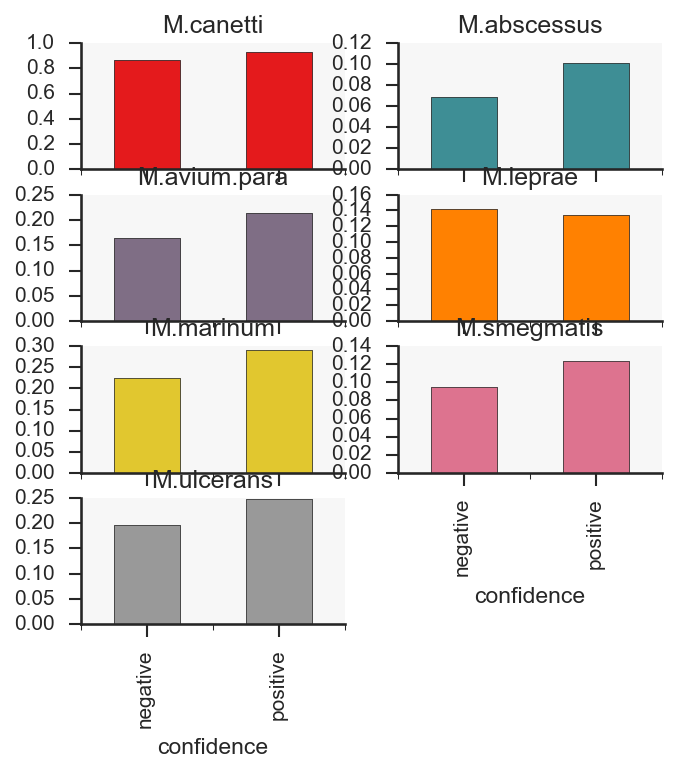

In [278]:
sns.set_context("notebook", font_scale=1.0)
s = pd.read_csv('peptide_conservation.csv',index_col=0)
#replace col names with species
spnames = {'MAB':'M.abscessus','MAF':'M.africanum','MAP':'M.avium.para','ML':'M.leprae','MMA':'M.marinum',
           'Rv':'MTB-H37Rv','MUL':'M.ulcerans','BN':'M.canetti','Mb':'M.bovis','MSM':'M.smegmatis'}
species = spnames.values()
s=s.rename(columns=spnames)
s=s.fillna('negative')
#sort by counts on both axes
#s=s.set_index(['confidence','peptide']) #'['locus_tag','peptide'])
#s=s.reindex_axis(s.sum().order().index, axis=1)
#s=s.reindex_axis(s.sum(1).order().index)

s.ix[s.confidence!='negative','confidence'] = 'positive'

#s=s.sortlevel()
totals = s.sum(1).order(ascending=False)
a = s[s.confidence=='negative']
b = s[s.confidence=='positive']  
g = s.groupby('confidence').agg(lambda x: x.sum()/x.count())
print g

#z-test for significance of proportions?
from statsmodels.stats.weightstats import ztest
for i in s.columns[:7]:
    z=ztest(a[i],b[i])
    print i, z[1]

#fig,ax = plt.subplots(1,1,figsize=(5,5))
#analysis.plotheatmap(g,ax)
g.plot(y=g.columns[:7],layout=(4,2),legend=False,colormap='Set1',       
       kind='bar',figsize=(5,5),subplots=True)
sns.despine()

#plt.savefig('peptide_conservation_map.png')

In [ ]:
#homology of 20mers within m.bovis?
reload(analysis)
db = os.path.join(home,'myco_genomes/mbovis') #local blastdb
x = res[res['#wbpos']>=50].dropna(subset=['pep_no'])

cons=[]
for i,r in list(x.iterrows()):
    #print i, r.peptide, r.locus_tag
    tag = r.locus_tag
    seq = r.peptide
    #blast local db
    recs = analysis.getLocalOrthologs(seq,db)
    if len(recs)>1:
        print tag, r['product']
        print recs
    

In [31]:
#overlap with known iedb tcell epitopes?
iedb = pd.read_csv('iedb_myco_tcell.csv')
iedb=iedb.drop_duplicates('peptide')
iedb = iedb[iedb['Source Organism Name'].str.contains('bovis')]
#print iedb.groupby('Source Molecule Name').size()

In [117]:
#position of Rv3874 in all tepitope binders
b=b4
sb = b.sort('score',ascending=0)
#sb = b.sort('1-log50k(aff)')
sb =sb.reset_index()
print len(sb)
print sb[sb.name=='Rv3874']

47370
       index  allele       core    name    peptide  pos   score    method  nearest
10842      0       8  IRQAGVQYS  Rv3874  IRQAGVQYS   75  4.4000  tepitope       20
31101      1       4  MKTDAATLA  Rv3874  MKTDAATLA    3  3.3000  tepitope       52
35932      2       5  VRFQEAANK  Rv3874  VRFQEAANK   55  3.0992  tepitope       20


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [276]:
#calculation 20mers in proteome
n=20
prots=len(mbovis)
l=(mbovis.length-n-1).sum()
nmers = l*n*prots
print prots, l

3961 1228066.0
